✅ 采样完成:  (100000, 5)
📊 类别分布:  Counter({np.uint8(0): 98349, np.uint8(1): 1651})
🎯 IoU on test image #400: 0.2103


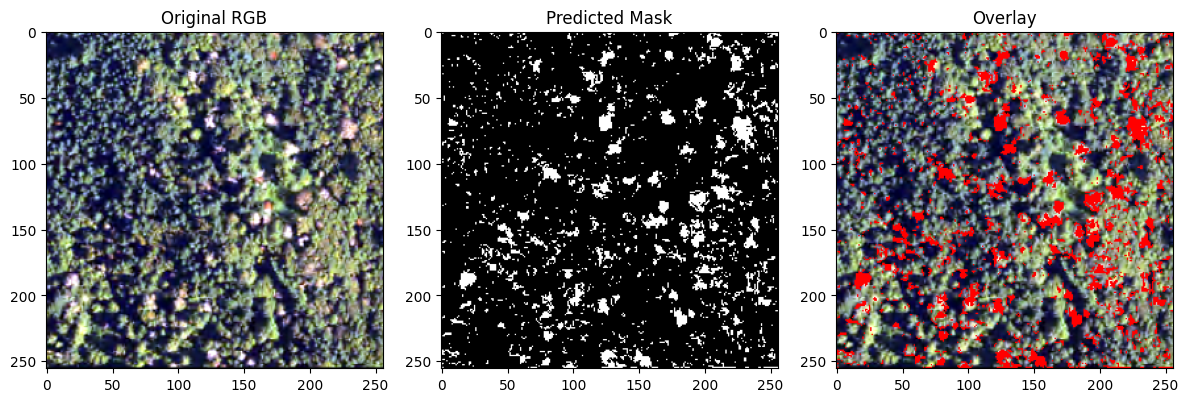

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score

def load_training_data(rgb_dir, nir_dir, mask_dir, image_size=(256, 256), max_images=300, sample_size=100_000):
    X_full = []
    y_full = []

    rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(('.png', '.jpg'))])[:max_images]
    nir_files = sorted([f for f in os.listdir(nir_dir) if f.endswith(('.png', '.jpg'))])[:max_images]
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])[:max_images]

    for rgb_file, nir_file, mask_file in zip(rgb_files, nir_files, mask_files):
        rgb_path = os.path.join(rgb_dir, rgb_file)
        nir_path = os.path.join(nir_dir, nir_file)
        mask_path = os.path.join(mask_dir, mask_file)

        rgb = cv2.imread(rgb_path)
        nir = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if rgb is None or nir is None or mask is None:
            continue

        rgb = cv2.resize(rgb, image_size)
        nir = cv2.resize(nir, image_size)
        mask = cv2.resize(mask, image_size)

        R = rgb[:, :, 0].astype(np.float32).flatten()
        G = rgb[:, :, 1].astype(np.float32).flatten()
        B = rgb[:, :, 2].astype(np.float32).flatten()
        N = nir.astype(np.float32).flatten()
        NDVI = (N - R) / (N + R + 1e-5)
        features = np.stack([R, G, B, N, NDVI], axis=1)
        labels = (mask.flatten() > 127).astype(np.uint8)

        X_full.append(features)
        y_full.append(labels)

    X_full = np.vstack(X_full)
    y_full = np.hstack(y_full)

    # 随机采样
    np.random.seed(42)
    indices = np.random.choice(len(X_full), size=sample_size, replace=False)
    X_sample = X_full[indices]
    y_sample = y_full[indices]

    print("✅ 采样完成: ", X_sample.shape)
    print("📊 类别分布: ", Counter(y_sample))
    return X_sample, y_sample

def train_svm(X, y):
    clf = SVC(kernel='rbf', class_weight='balanced')
    clf.fit(X, y)
    return clf

def predict_image(model, rgb_path, nir_path, image_size=(256, 256)):
    rgb = cv2.imread(rgb_path)
    nir = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)

    rgb = cv2.resize(rgb, image_size)
    nir = cv2.resize(nir, image_size)

    R = rgb[:, :, 0].astype(np.float32).flatten()
    G = rgb[:, :, 1].astype(np.float32).flatten()
    B = rgb[:, :, 2].astype(np.float32).flatten()
    N = nir.astype(np.float32).flatten()
    NDVI = (N - R) / (N + R + 1e-5)

    features = np.stack([R, G, B, N, NDVI], axis=1)
    pred = model.predict(features)
    return pred.reshape(image_size)

def evaluate(pred_mask, true_mask):
    pred_flat = pred_mask.flatten()
    true_flat = (true_mask.flatten() > 127).astype(np.uint8)
    return jaccard_score(true_flat, pred_flat)

def visualize(rgb_path, pred_mask):
    rgb = cv2.imread(rgb_path)
    rgb = cv2.resize(rgb, pred_mask.shape[::-1])
    overlay = rgb.copy()
    overlay[pred_mask == 1] = [0, 0, 255]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB))
    plt.title("Original RGB")
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlay")
    plt.tight_layout()
    plt.show()

# ========= 主程序 =========

rgb_dir = "./data/USA_segmentation/RGB_images"
nir_dir = "./data/USA_segmentation/NRG_images"
mask_dir = "./data/USA_segmentation/masks"

X, y = load_training_data(rgb_dir, nir_dir, mask_dir, max_images=300, sample_size=100_000)
model = train_svm(X, y)

test_idx = 400
rgb_files = sorted([f for f in os.listdir(rgb_dir) if f.endswith(('.png', '.jpg'))])
nir_files = sorted([f for f in os.listdir(nir_dir) if f.endswith(('.png', '.jpg'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.png', '.jpg'))])

test_rgb_path = os.path.join(rgb_dir, rgb_files[test_idx])
test_nir_path = os.path.join(nir_dir, nir_files[test_idx])
test_mask_path = os.path.join(mask_dir, mask_files[test_idx])

pred = predict_image(model, test_rgb_path, test_nir_path)
true_mask = cv2.imread(test_mask_path, cv2.IMREAD_GRAYSCALE)
true_mask = cv2.resize(true_mask, pred.shape[::-1])

iou = evaluate(pred, true_mask)
print(f"🎯 IoU on test image #{test_idx}: {iou:.4f}")
visualize(test_rgb_path, pred)
